Данные возьмём с соревнований Кагл.

In [111]:
import random
import os
from urllib.request import urlretrieve
from tqdm import tqdm
import cv2
from collections import defaultdict
import copy

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

In [112]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

In [113]:
# dataset_directory = os.path.join(os.getcwd(), "glasses_or_no_glasses/faces_meglass/MeGlass_120x120/")
dataset_directory = os.path.join(os.getcwd(), "glasses_or_no_glasses/faces_meglass/crop_test/")

In [114]:
target_vector = pd.read_csv('glasses_or_no_glasses/faces_meglass/meta.csv', names=['id', 'glasses'])

In [115]:
# images_filepaths = [os.path.join(dataset_directory, d) for d in os.listdir(dataset_directory)]


In [116]:

# temp_paths = []
# for image in tqdm(images_filepaths):
#     image_name = image[len(dataset_directory):]
#     image_label = int(target_vector[target_vector['id'] == image_name]['glasses'])
#     temp_paths.append((image, image_label))
# images_filepaths = temp_paths


In [117]:
import pickle
# with open('img_path_tuples', 'wb') as f:
#     pickle.dump(images_filepaths, f)
with open('img_path_tuples', 'rb') as f:
    images_filepaths = pickle.load(f)

In [118]:
random.seed(42)
random.shuffle(images_filepaths)
train_images_filepaths = images_filepaths[:40000]
val_images_filepaths = images_filepaths[40000:47000]
test_images_filepaths = images_filepaths[47000:len(images_filepaths)]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

40000 7000 917


Свой датасет

In [119]:
class GlassesDataset(Dataset):
    def __init__(self, images_filepaths, targets=target_vector, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform
        self.targets = targets

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image, label = self.images_filepaths[idx]
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [120]:
# resize = A.Compose([
#     A.Resize(224,224)
# ]) 
# for image in tqdm(images_filepaths):
#     image_name = image[len(dataset_directory):]

#     image = cv2.imread(image)

#     image = resize(image=image)["image"]
#     cv2.imwrite(f'glasses_or_no_glasses/faces_meglass/crop_test/{image_name}', image)

Мониторинг метрик:

In [121]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [122]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

Функции обучения\валидации

In [123]:
params = {
    "lr": 0.001,
    "batch_size": 128,
    "num_workers": 2,
    "epochs": 5,
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device} selected')

cuda selected


In [124]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        if device.type == 'cuda':
            images = images.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True).float().view(-1, 1)
        else:
            target = target.float().view(-1, 1)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [125]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            if device.type == 'cuda':
                images = images.to(device, non_blocking=True)
                target = target.to(device, non_blocking=True).float().view(-1, 1)
            else:
                target = target.float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [126]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

train_transform = A.Compose([
                            # A.Resize(224,224),
                            A.Affine(translate_percent=0.1, rotate=(-25, 25), p=0.35),
                            # A.Affine(scale={'x':0.75, 'y':1}),
                            # A.Affine(scale={'x':1, 'y':0.75}),
                            # A.Blur(blur_limit=4),
                            A.CoarseDropout(max_holes=5, max_height=32, max_width=32, min_width=16, min_height=16, min_holes=3),
                            A.Flip(p=0.5),
                            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
                            A.RandomBrightnessContrast(p=0.5),
                            A.Normalize(mean=mean, std=std),
                            ToTensorV2(),
])
basic_transform = A.Compose([
                            # A.Resize(224,224),
                             A.Normalize(mean=mean, std=std),
                            ToTensorV2(),
])

train_dataset = GlassesDataset(images_filepaths=train_images_filepaths, transform=train_transform)
val_dataset = GlassesDataset(images_filepaths=val_images_filepaths, transform=basic_transform)
test_dataset = GlassesDataset(images_filepaths=test_images_filepaths, transform=basic_transform)

In [127]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()    

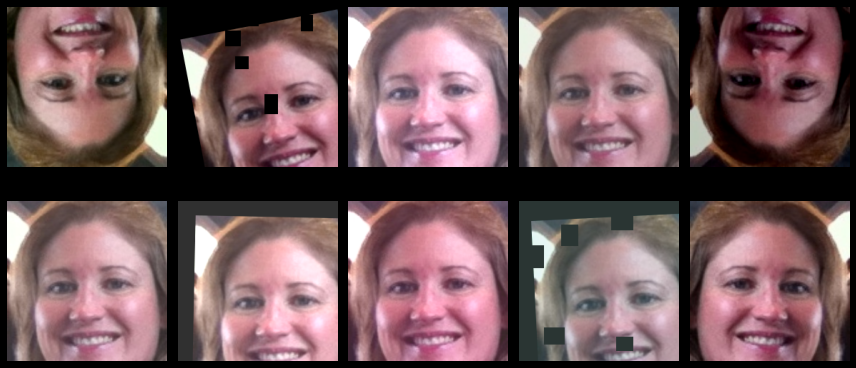

In [128]:
random.seed(44)
visualize_augmentations(train_dataset)

In [129]:
class DetectionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(3, 16, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            # nn.Conv2d(64, 96, 3, stride=2, padding=2),
            # nn.LeakyReLU(0.1),
            # nn.BatchNorm2d(96),
            nn.AdaptiveMaxPool2d(16),
        )

        self.decoder = nn.Sequential(
            nn.Dropout2d(p=0.2),
            nn.Linear(16**2*64, 1)
        )

    def forward(self, images):
        x = self.layer(images)
        x = x.view(-1, 16**2*64)
        x = self.decoder(x)
        return x

In [130]:
# model = DetectionModel()
model = getattr(models, 'mobilenet_v3_small')(pretrained=True,)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=48, out_features=1, bias=True),
    # nn.Hardswish(),
    # nn.Linear(in_features=1024, out_features=1, bias=True)
)
model.features = nn.Sequential(*list(model.children())[-3][:8])

In [131]:
if device.type == 'cuda':
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
else:
    criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])


train_loader = DataLoader(train_dataset, batch_size=params["batch_size"],
                            shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=params["batch_size"],
                    shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"],
                            shuffle=False, pin_memory=True)

for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

model = model.eval()
predicted_labels = []
with torch.no_grad():
    for images, target in test_loader:
        if device.type == 'cuda':
            images = images.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True).float().view(-1, 1)
        else:
            target = target.float().view(-1, 1)
        output = model(images)
        predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
        predicted_labels += [1 if label else 0 for label in predictions]
    print(f'Accuracy = {calculate_accuracy(output, target):.2%}')

Epoch: 1. Train.      Loss: 0.080 | Accuracy: 0.974: 100%|██████████| 313/313 [04:36<00:00,  1.13it/s]
Epoch: 1. Validation. Loss: 0.012 | Accuracy: 0.996: 100%|██████████| 55/55 [00:36<00:00,  1.51it/s]
Epoch: 2. Train.      Loss: 0.014 | Accuracy: 0.996: 100%|██████████| 313/313 [04:07<00:00,  1.27it/s]
Epoch: 2. Validation. Loss: 0.007 | Accuracy: 0.997: 100%|██████████| 55/55 [00:31<00:00,  1.76it/s]
Epoch: 3. Train.      Loss: 0.010 | Accuracy: 0.997: 100%|██████████| 313/313 [03:59<00:00,  1.31it/s]
Epoch: 3. Validation. Loss: 0.005 | Accuracy: 0.999: 100%|██████████| 55/55 [00:31<00:00,  1.73it/s]
Epoch: 4. Train.      Loss: 0.009 | Accuracy: 0.997: 100%|██████████| 313/313 [03:58<00:00,  1.31it/s]
Epoch: 4. Validation. Loss: 0.005 | Accuracy: 0.998: 100%|██████████| 55/55 [00:31<00:00,  1.75it/s]
Epoch: 5. Train.      Loss: 0.008 | Accuracy: 0.998: 100%|██████████| 313/313 [03:57<00:00,  1.32it/s]
Epoch: 5. Validation. Loss: 0.003 | Accuracy: 0.999: 100%|██████████| 55/55 [00:3

Accuracy = 95.24%


In [132]:
torch.save(model.state_dict(), 'trained_model/mobnet_weights.pt')

In [133]:
model_weights = []
conv_layers = []
model_children = list(model.children())

In [134]:
l = [module for module in model.modules() if not isinstance(module, nn.Sequential)]

counter = 0 
for i in range(len(l)):
    if type(l[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(l[i].weight)
        conv_layers.append(l[i])
    elif type(l[i]) == nn.Sequential:
        for j in range(len(l[i])):
            for child in l[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 31


In [135]:
img = cv2.imread(images_filepaths[3][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# plt.show()

transform = A.Compose([
                A.Resize(224,224),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),  
])
img = np.array(img)
img = transform(image=img)['image']
img = img.unsqueeze(0)

In [136]:

results = [conv_layers[0](img.to(device, non_blocking=True))]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))

outputs = results

In [137]:
# for num_layer in range(len(outputs)): # после первых 6 слоёв пропадает возможность интерпретации.
#     plt.figure(figsize=(30, 30))
#     layer_viz = outputs[num_layer][0, :, :, :]
#     layer_viz = layer_viz.data
#     print(layer_viz.size())
#     for i, filter in enumerate(layer_viz):
#         if i == 64:
#             break
#         plt.subplot(8, 8, i + 1)
#         plt.imshow(filter.cpu().numpy(), cmap='gray')
#         plt.axis("off")
#     print(f"Plotting layer {num_layer} feature maps...")
#     plt.show()
#     # plt.close()

In [138]:
def visualize_augmentations(dataset, idx=1, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()    

In [139]:
import time


img_dir = 'test_data/'

class GlassesDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(os.path.join(img_dir, image_filepath))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = np.array(image)
            image = self.transform(image=image)["image"]
        return image


model_path = os.path.join(os.getcwd(), 'trained_model/mobnet_weights.pt')
model.load_state_dict(torch.load(model_path))
model = model.eval()

images_paths = os.listdir(img_dir)
target = torch.Tensor([0 if ')' in filename else 1 for filename in images_paths])
eval_transform = A.Compose([
                    A.SmallestMaxSize(max_size=300),
                    A.CenterCrop(height=224, width=224),
                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                    ToTensorV2(),
])

images_dataset = GlassesDataset(images_filepaths=images_paths, transform=eval_transform)
image_loader = DataLoader(images_dataset, batch_size=128, shuffle=False, pin_memory=True)

def calculate_accuracy(predictions, target):
    predictions = torch.sigmoid(predictions) >= 0.5
    target = target.view(-1, 1) == 1
    return torch.true_divide((target == predictions).sum(dim=0), output.size(0)).item()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device, non_blocking=True)
# device = torch.device('cpu')
start_time = time.time()

predicted_paths = []
with torch.no_grad():
    for images in image_loader:
        if device.type == 'cuda':
            images = images.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
        output = model(images)
        predictions = (torch.sigmoid(output) >= 0.5)[:, 0]
        predicted_paths += [images_paths[i] for i, gls_detected in enumerate(predictions) if gls_detected]
    print(f'\n---Accuracy = {calculate_accuracy(output, target):.2%}---\n')

inf_time = time.time() - start_time
[print(path) for path in predicted_paths]
print(f'\n---Inference time: {(inf_time) / len(images_paths) * 1000:.2f} milliseconds per image ---\n')






---Accuracy = 97.50%---

0.jpg
1.jpg
10.jpg
11.jpg
12.jpg
13.jpg
14.jpg
15.jpg
16.jpg
17.jpg
19.jpg
2.jpg
3.jpg
4.jpg
5.jpg
6.jpg
7.jpg
8.jpg
9.jpg

---Inference time: 18.63 milliseconds per image ---



In [140]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=8):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(24, 12))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(os.path.join('test_data/', image_filepath) )
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = 0 if ')' in image_filepath else 1
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()